In [1]:
import pandas_datareader as pdr
import pandas as pd
import os

In [2]:
#loading the stock price data 
key = '********************************'
df = pdr.get_data_tiingo('GOOG', api_key=key)

In [3]:
df

close       high  ...  divCash  splitFactor
symbol date                                           ...                      
GOOG   2016-07-13 00:00:00+00:00   716.98   724.0000  ...      0.0          1.0
       2016-07-14 00:00:00+00:00   720.95   722.2100  ...      0.0          1.0
       2016-07-15 00:00:00+00:00   719.85   725.7400  ...      0.0          1.0
       2016-07-18 00:00:00+00:00   733.78   736.1300  ...      0.0          1.0
       2016-07-19 00:00:00+00:00   736.96   736.9900  ...      0.0          1.0
...                                   ...        ...  ...      ...          ...
       2021-07-02 00:00:00+00:00  2574.38  2576.9600  ...      0.0          1.0
       2021-07-06 00:00:00+00:00  2595.42  2597.6900  ...      0.0          1.0
       2021-07-07 00:00:00+00:00  2601.55  2612.7983  ...      0.0          1.0
       2021-07-08 00:00:00+00:00  2583.54  2600.6500  ...      0.0          1.0
       2021-07-09 00:00:00+00:00  2591.49  2596.9900  ...      0.0          1.0

[1257 rows x 12 columns]

In [4]:
df.to_csv('APPL.csv')

In [5]:
df = pd.read_csv('/content/APPL.csv')

In [6]:
df

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GOOG,2016-07-13 00:00:00+00:00,716.98,724.0000,716.850,723.62,935876,716.98,724.0000,716.850,723.62,935876,0.0,1.0
1,GOOG,2016-07-14 00:00:00+00:00,720.95,722.2100,718.030,721.58,950193,720.95,722.2100,718.030,721.58,950193,0.0,1.0
2,GOOG,2016-07-15 00:00:00+00:00,719.85,725.7400,719.055,725.73,1279339,719.85,725.7400,719.055,725.73,1279339,0.0,1.0
3,GOOG,2016-07-18 00:00:00+00:00,733.78,736.1300,721.190,722.71,1295476,733.78,736.1300,721.190,722.71,1295476,0.0,1.0
4,GOOG,2016-07-19 00:00:00+00:00,736.96,736.9900,729.000,729.89,1227486,736.96,736.9900,729.000,729.89,1227486,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,GOOG,2021-07-02 00:00:00+00:00,2574.38,2576.9600,2535.380,2536.79,1058256,2574.38,2576.9600,2535.380,2536.79,1058256,0.0,1.0
1253,GOOG,2021-07-06 00:00:00+00:00,2595.42,2597.6900,2568.180,2588.99,1067517,2595.42,2597.6900,2568.180,2588.99,1067517,0.0,1.0
1254,GOOG,2021-07-07 00:00:00+00:00,2601.55,2612.7983,2595.200,2606.82,834186,2601.55,2612.7983,2595.200,2606.82,834186,0.0,1.0
1255,GOOG,2021-07-08 00:00:00+00:00,2583.54,2600.6500,2560.800,2565.00,988975,2583.54,2600.6500,2560.800,2565.00,988975,0.0,1.0


In [7]:
df1 = df.reset_index()['close']

In [8]:
df1.shape,type(df1)

((1257,), pandas.core.series.Series)

In [9]:
import matplotlib.pyplot as plt


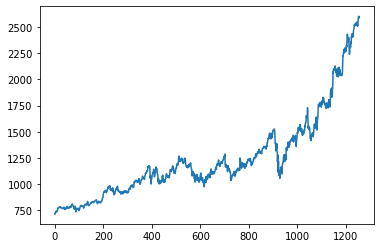

In [10]:
plt.plot(df1)

In [11]:
## LSTM are sensitive to the scale of data. so convert the data using minmax scaler
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler  = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [12]:
print(df1)

[[0.        ]
 [0.00210658]
 [0.00152289]
 ...
 [1.        ]
 [0.99044344]
 [0.99466191]]


In [13]:
## splitting the data into train and test
training_size = int(len(df1)*0.7) 
test_size = len(df1)-training_size
train_data,test_data = df1[0:training_size,:],df1[training_size:len(df1)]

In [14]:
len(test_data)

378

In [15]:
#convert an array value into dataset matrix
def create_matrix(dataset,time_step):
  data_X,data_y = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    data_X.append(a)
    data_y.append(dataset[i+time_step,0])
  return np.array(data_X),np.array(data_y)

In [16]:
time_step = 100
X_train,y_train = create_matrix(train_data,time_step)
X_test,y_test = create_matrix(test_data,time_step)

In [17]:
##reshape input
X_train  = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test  = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [18]:
# creating the stack LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [19]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape = (100,1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error',optimizer = 'adam')

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs = 100,batch_size = 64,verbose=1)

In [23]:
# prediction and performance matrix
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
train_predict

In [25]:
# transfer back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
train_predict

In [ ]:
## calculate RMSE and performance matrix
import math 
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


In [ ]:
math.sqrt(mean_squared_error(y_test,test_predict))